## Zip File 풀기

In [1]:
# import zipfile
         
# fantasy_zip = zipfile.ZipFile('sketches_png.zip')
# fantasy_zip.extractall('sketch_png')
 
# fantasy_zip.close()

## 데이터 불러오기


In [2]:
import cv2
import matplotlib.pyplot as plt
import random
import os
import matplotlib.image as mpimg
import pickle
import numpy as np

In [ ]:
IMG_WIDTH=128
IMG_HEIGHT=128

img_data_array=[]
class_name=[]

img_folder = 'sketch_png'
for dir1 in os.listdir(img_folder):
    try:
        for file in os.listdir(os.path.join(img_folder, dir1)):       
            try:
                image_path= os.path.join(img_folder, dir1,  file)
                image= cv2.imread(image_path, cv2.COLOR_BGR2RGB)
                image=cv2.resize(image, (IMG_HEIGHT, IMG_WIDTH),interpolation = cv2.INTER_AREA)
                image=np.array(image)
                image = image.astype('float32')
                image /= 255 
                img_data_array.append(image)
                class_name.append(dir1)        
            except:
                print(dir1,file)
                pass
    except:
        pass

ear 5920.png
ear 5847.png
tennis-racket 17706.png
tennis-racket 17689.png
crocodile 4985.png
crocodile 5030.png
microphone 10372.png


## 데이터 확인

In [ ]:
plt.figure(figsize=(20,20))

img_folder='sketch_png/airplane'

for i in range(1):
    file = random.choice(os.listdir(img_folder))
    image_path= os.path.join(img_folder, file)
    img=mpimg.imread(image_path)
    print(img.shape)
    ax=plt.subplot(1,5,i+1)
    ax.title.set_text(file)
    plt.imshow(img, cmap='gray')

##  데이터 저장

In [5]:
# with open("png_data.pickle",'wb') as fw:
#     pickle.dump(img_data_array, fw)
# with open("label_data.pickle",'wb') as fw:
#     pickle.dump(class_name, fw)

## 데이터 불러오기

In [6]:
with open("png_data.pickle",'rb') as fr:
    img_data_array = pickle.load(fr)
with open("label_data.pickle",'rb') as fr:
    class_name = pickle.load(fr)

In [7]:
np.array(img_data_array).shape

(20000, 128, 128)

## 데이터 형변환


In [8]:
## X data reshape
img_data_array = np.array(img_data_array)
img_data_array = img_data_array.reshape(img_data_array.shape[0],img_data_array.shape[1],img_data_array.shape[2],-1)
img_data_array.shape

(20000, 128, 128, 1)

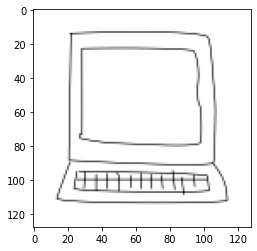

In [9]:
plt.imshow(img_data_array[100], cmap = 'gray')

In [10]:
## Y data label encoding
import pandas as pd
temp_df = pd.DataFrame(columns = ['label'], data = class_name)

label_index = list(set(class_name))
label_dict = {string : i for i,string in enumerate(label_index)}

temp_df['label'].replace(label_dict, inplace =True)
class_name = temp_df['label'].values

## Train/Test Split (8:2)

In [11]:
from sklearn.model_selection import train_test_split
train_scaled, val_scaled, train_target, val_target = train_test_split(img_data_array, class_name, test_size=0.2, random_state=42)
train_scaled = np.array(train_scaled)

## Model - Conv2D

In [12]:
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score, precision_score, recall_score
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, Input, Conv2DTranspose, Concatenate, Resizing, BatchNormalization
from tensorflow.keras import backend as K 
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf
from tensorflow import keras
tf.random.set_seed(42)

In [13]:
train_scaled.shape[1:]

(128, 128, 1)

In [ ]:
model = Sequential()
model.add(Conv2D(16, (3, 3), activation='relu', input_shape = train_scaled.shape[1:]))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(32, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(len(np.unique(train_target)),activation = 'softmax'))

model.summary()

In [14]:
K.clear_session()
model = Sequential()
model.add(Conv2D(32, 3, padding = 'same', activation = 'relu', input_shape = train_scaled.shape[1:]))
model.add(Conv2D(64, 2, padding = 'same', activation = 'relu'))
model.add(MaxPooling2D(2))
model.add(Flatten())
model.add(Dense(256, activation = 'relu'))
model.add(Dropout(0.4))
model.add(Dense(len(np.unique(train_target)), activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      8256      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 262144)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               67109120  
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               6

In [15]:
model.compile(optimizer='SGD', loss='sparse_categorical_crossentropy', metrics='accuracy')
early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10,restore_best_weights=True, mode='min')
history = model.fit(train_scaled, train_target, epochs=100, batch_size = 64 , validation_data=(val_scaled, val_target), callbacks = early_stopping_callback)

Epoch 1/100
Extension horovod.torch has not been built: /usr/local/lib/python3.8/site-packages/horovod/torch/mpi_lib/_mpi_lib.cpython-38-x86_64-linux-gnu.so not found
If this is not expected, reinstall Horovod with HOROVOD_WITH_PYTORCH=1 to debug the build error.
Warning! MPI libs are missing, but python applications are still avaiable.
[2022-08-01 06:33:57.815 tensorflow-2-6-cpu--ml-g4dn-xlarge-46981aad7de2c9ad4ff237041403:1152 INFO utils.py:27] RULE_JOB_STOP_SIGNAL_FILENAME: None
[2022-08-01 06:33:57.964 tensorflow-2-6-cpu--ml-g4dn-xlarge-46981aad7de2c9ad4ff237041403:1152 INFO profiler_config_parser.py:111] Unable to find config at /opt/ml/input/config/profilerconfig.json. Profiler is disabled.
250/250 [==============================] - 175s 695ms/step - loss: 5.5234 - accuracy: 0.0029 - val_loss: 5.5216 - val_accuracy: 0.0022
Epoch 2/100
250/250 [==============================] - 173s 692ms/step - loss: 5.5215 - accuracy: 0.0028 - val_loss: 5.5217 - val_accuracy: 0.0022
Epoch 3/100


KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'])
plt.show()

In [ ]:
mode = 'val'

pred = model.predict(globals()[f'{mode}_scaled'])
pred = np.argmax(pred, axis = 1)

f1_ = f1_score(globals()[f'{mode}_target'], pred, average = 'macro')
acc_ = accuracy_score(globals()[f'{mode}_target'], pred)
prec_ = precision_score(globals()[f'{mode}_target'], pred, average = 'macro')
recall_ = recall_score(globals()[f'{mode}_target'], pred, average = 'macro')

print(f'f1_score : {f1_} \nacc_score : {acc_}\nprecicion_score : {prec_}\nrecall_score : {recall_}')
confusion_matrix(globals()[f'{mode}_target'], pred)

<AxesSubplot:>

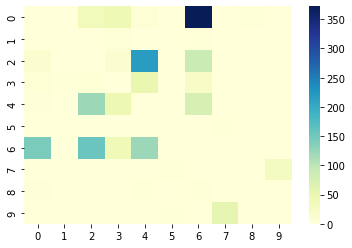

In [85]:
import seaborn as sns
classes = ['티셔츠', '바지', '스웨터', '드레스', '코트', '샌달', '셔츠', '스니커즈', '가방', '앵클 부츠']
confusion_max = confusion_matrix(globals()[f'{mode}_target'], pred)
np.fill_diagonal(confusion_max, 0)

sns.heatmap(confusion_max, cmap="YlGnBu")

## Model Test

In [72]:
from tensorflow.python.keras.applications.vgg16 import VGG16
from tensorflow.python.keras.applications.vgg19 import VGG19
### Image sizing 조절 layer : Resizing, Conv2DTranspose(Autoencoder 생성의 경우 많이 쓰이는 듯)

In [73]:
## VGG 모델 불러오기
base_model = VGG16(include_top = False, weights = "imagenet", input_shape = (32,32,3))
base_model.trainable = False ## 가중치 고정
# base_model.summary()

In [74]:
## 가중치 고정 안된 layer 있는지 확인
for i in base_model.layers:
    if len(i.non_trainable_weights) < 0:
        print(i.name)
        print(len(i.non_trainable_weights))        

In [75]:
# ## Resizing을 통한 모델 결합
# K.clear_session()
# resize_model = Sequential()
# resize_model.add(Input(shape = train_scaled.shape[1:]))
# resize_model.add(Resizing(32,32, interpolation = 'gaussian'))
# resize_model.add(Conv2D(3,3,padding = 'same', activation = 'relu'))
# resize_model.add(base_model)
# resize_model.add(Flatten())
# resize_model.add(Dense(len(np.unique(test_target)), activation = 'relu'))
# resize_model.summary()

In [76]:
# resize_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
# early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, mode='min')
# history = resize_model.fit(train_scaled, train_target, epochs=100, batch_size = 32 , validation_data=(val_scaled, val_target), callbacks = early_stopping_callback)

In [77]:
# ## Conv2D Trans를 통한 모델 결합
# K.clear_session()
# test_model = Sequential()
# test_model.add(Input(shape = train_scaled.shape[1:]))
# test_model.add(Conv2DTranspose(3,5,padding = 'valid'))
# test_model.add(base_model)
# test_model.add(Flatten())
# test_model.add(Dense(len(np.unique(test_target))))
# test_model.summary()

In [78]:
# test_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
# early_stopping_callback = EarlyStopping(monitor='val_loss', min_delta=0.001, patience=10, mode='min')
# history = test_model.fit(train_scaled, train_target, epochs=100, batch_size = 64 , validation_data=(val_scaled, val_target), callbacks = early_stopping_callback)